In [1]:
# Install RDKit in Colab
!pip install rdkit-pypi


In [2]:
pip install torch torchvision torchaudio


In [3]:
# Install PyTorch (CPU version) if not already
!pip install torch torchvision torchaudio

# Install PyTorch Geometric dependencies
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html

# Install PyG itself
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html


In [4]:
# Downgrade numpy first to a compatible version
!pip install numpy==1.24.3

# Restart runtime manually after this cell runs!

# Then install RDKit
!pip install rdkit-pypi


In [2]:
# 1. Import necessary libraries
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
from torch_geometric.data import Data


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

In [3]:
def atom_features(atom):
  return torch.tensor([
      atom.GetAtomicNum(),
      atom.GetDegree(),
      atom.GetImplicitValence(),
      atom.GetFormalCharge(),
      int(atom.GetIsAromatic())
  ], dtype=torch.float)

In [4]:
def smiles_to_graph(smiles, drug_id=None):
  mol = Chem.MolFromSmiles(smiles)
  if mol is None:
    return None

  atom_list = [atom_features(atom) for atom in mol.GetAtoms()]
  x = torch.stack(atom_list)

  edge_index = []
  edge_attr = []

  for bond in mol.GetBonds():
    i = bond.GetBeginAtomIdx()
    j = bond.GetEndAtomIdx()

    edge_index.append([i, j])
    edge_index.append([j, i])

    bond_type = bond.GetBondTypeAsDouble()
    edge_attr.append([bond_type])
    edge_attr.append([bond_type])

  edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
  edge_attr = torch.tensor(edge_attr, dtype=torch.float)

  return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles = smiles , drug_id=drug_id)

In [5]:
import pandas as pd

drug_df = pd.read_csv('/content/drive/MyDrive/drugbank_extracted.csv')

molecular_graphs = []

for index, row in drug_df.iterrows():
    smiles = str(row['smiles'])
    drug_id = row['drugbank_id']

    if smiles.lower() == 'nan' or smiles.strip() == '':
        continue

    graph = smiles_to_graph(smiles, drug_id=drug_id)
    if graph is not None:
        molecular_graphs.append(graph)


[07:37:17] Explicit valence for atom # 0 N, 4, is greater than permitted
[07:37:17] Explicit valence for atom # 0 N, 4, is greater than permitted
[07:37:18] Explicit valence for atom # 0 N, 4, is greater than permitted
[07:37:19] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[07:37:19] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[07:37:19] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
[07:37:20] Explicit valence for atom # 19 O, 3, is greater than permitted
[07:

In [6]:
# 5. Optional: Save all molecular graphs (later we can batch them)
torch.save(molecular_graphs, 'molecular_graphs.pt')


In [7]:
import torch

In [8]:
molecular_graphs = torch.load('molecular_graphs.pt',weights_only=False)

In [9]:
drug_id_to_index = {}
for idx, graph in enumerate(molecular_graphs):
  drug_id_to_index[graph.drug_id] = idx

In [10]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/drugbank_extracted.csv')


In [11]:
edge_index_list = []
for _, row in df.iterrows():
  src_id = row['drugbank_id']
  if src_id not in drug_id_to_index:
    continue
  interactions = str(row['interactions']).split('|')

  for tgt_id in interactions:
    if tgt_id in drug_id_to_index:
      src_idx = drug_id_to_index[src_id]
      tgt_idx = drug_id_to_index[tgt_id]
      edge_index_list.append([src_idx, tgt_idx])

In [12]:
import torch

# Convert to PyTorch Geometric format
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()


In [13]:
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np

def smiles_to_fp(smiles, drug_id=None):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=128)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return torch.tensor(arr, dtype=torch.float), drug_id

node_features = []
drug_id_to_index = {}

for idx, row in drug_df.iterrows():
    smiles = row['smiles']
    drug_id = row['drugbank_id']
    if pd.isna(smiles):
        continue
    result = smiles_to_fp(smiles, drug_id)
    if result is None:
      continue
    fp, did = result
    drug_id_to_index[did] = len(node_features)
    node_features.append(fp)

    x = torch.stack(node_features)


[07:37:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[07:37:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[07:37:48] Explicit valence for atom # 0 N, 4, is greater than permitted
[07:37:49] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[07:37:49] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[07:37:49] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
[07:37:51] Explicit valence for atom # 19 O, 3, is greater than permitted
[07:

In [14]:
from torch_geometric.data import Data

ddi_graph = Data(x=x, edge_index=edge_index)


In [15]:
from torch_geometric.utils import train_test_split_edges

ddi_graph = train_test_split_edges(ddi_graph)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [16]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNEncoder(torch.nn.Module):
  def __init__(self, in_channels, out_channels):
    super(GCNEncoder, self).__init__()
    self.conv1 = GCNConv(in_channels, 128)
    self.conv2 = GCNConv(128, out_channels)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    return x

In [17]:
from torch_geometric.nn import GAE
model = GAE(GCNEncoder(in_channels=128, out_channels=64))


In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [19]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(ddi_graph.x, ddi_graph.train_pos_edge_index)
    loss = model.recon_loss(z, ddi_graph.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return loss


In [20]:
from torch_geometric.utils import negative_sampling

@torch.no_grad()
def test():
    model.eval()
    z = model.encode(ddi_graph.x, ddi_graph.train_pos_edge_index)
    auc, ap = model.test(z, ddi_graph.test_pos_edge_index, ddi_graph.test_neg_edge_index)
    return auc, ap


In [21]:
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        auc, ap = test()
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, AP: {ap:.4f}")


Epoch 010, Loss: 1.4195, AUC: 0.6415, AP: 0.5330
Epoch 020, Loss: 1.3454, AUC: 0.7931, AP: 0.6794
Epoch 030, Loss: 1.2735, AUC: 0.8539, AP: 0.7586
Epoch 040, Loss: 1.1946, AUC: 0.8898, AP: 0.8048
Epoch 050, Loss: 1.1046, AUC: 0.9119, AP: 0.8388
Epoch 060, Loss: 1.0383, AUC: 0.9255, AP: 0.8648
Epoch 070, Loss: 0.9970, AUC: 0.9367, AP: 0.8930
Epoch 080, Loss: 0.9572, AUC: 0.9514, AP: 0.9268
Epoch 090, Loss: 0.9268, AUC: 0.9659, AP: 0.9551
Epoch 100, Loss: 0.8795, AUC: 0.9784, AP: 0.9740
Epoch 110, Loss: 0.8553, AUC: 0.9835, AP: 0.9801
Epoch 120, Loss: 0.8457, AUC: 0.9861, AP: 0.9831
Epoch 130, Loss: 0.8374, AUC: 0.9868, AP: 0.9837
Epoch 140, Loss: 0.8312, AUC: 0.9876, AP: 0.9845
Epoch 150, Loss: 0.8278, AUC: 0.9886, AP: 0.9856
Epoch 160, Loss: 0.8258, AUC: 0.9879, AP: 0.9847
Epoch 170, Loss: 0.8293, AUC: 0.9883, AP: 0.9853
Epoch 180, Loss: 0.8186, AUC: 0.9895, AP: 0.9865
Epoch 190, Loss: 0.8167, AUC: 0.9895, AP: 0.9866
Epoch 200, Loss: 0.8161, AUC: 0.9893, AP: 0.9864


In [24]:
# Final evaluation
model.eval()
z = model.encode(ddi_graph.x, ddi_graph.train_pos_edge_index)

from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, accuracy_score

# Positive edges
pos_edge_index = ddi_graph.test_pos_edge_index

# Negative edges (sampled)
neg_edge_index = negative_sampling(
    edge_index=ddi_graph.train_pos_edge_index,
    num_nodes=z.size(0),
    num_neg_samples=pos_edge_index.size(1)
)


# Score function
def decode_pairs(z, edge_index):
    scores = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
    return torch.sigmoid(scores)

# Predict
pos_scores = decode_pairs(z, pos_edge_index)
neg_scores = decode_pairs(z, neg_edge_index)

all_scores = torch.cat([pos_scores, neg_scores])
labels = torch.cat([
    torch.ones(pos_scores.size(0)),
    torch.zeros(neg_scores.size(0))
])

# Evaluation
scores_np = all_scores.detach().cpu().numpy()
labels_np = labels.detach().cpu().numpy()

auc = roc_auc_score(labels_np, scores_np)
acc = accuracy_score(labels_np, (scores_np >= 0.5).astype(int))

print(f"✅ ROC AUC Score: {auc:.4f}")
print(f"✅ Accuracy Score: {acc:.4f}")


✅ ROC AUC Score: 0.9880
✅ Accuracy Score: 0.7556


In [25]:
def predict_interaction(drug1_name, drug2_name, drug_df, model, z):
    d1_row = drug_df[drug_df['name'].str.lower() == drug1_name.lower()]
    d2_row = drug_df[drug_df['name'].str.lower() == drug2_name.lower()]

    if d1_row.empty or d2_row.empty:
        return f"Error: One or both drug names not found in dataset."

    id1 = d1_row['drugbank_id'].values[0]
    id2 = d2_row['drugbank_id'].values[0]

    idx1 = drug_id_to_index.get(id1)
    idx2 = drug_id_to_index.get(id2)

    if idx1 is None or idx2 is None:
        return f"Error: One or both drugs are not part of the trained graph."

    idx1 = int(idx1)
    idx2 = int(idx2)

    model.eval()
    # Directly compute similarity score
    score = torch.sigmoid((z[idx1] * z[idx2]).sum()).item()
    return f"Predicted interaction probability between {drug1_name} and {drug2_name}: {score:.4f}"


In [26]:
predict_interaction("Ezetimibe", "Carumonam", drug_df, model, z)


'Predicted interaction probability between Ezetimibe and Carumonam: 0.3237'

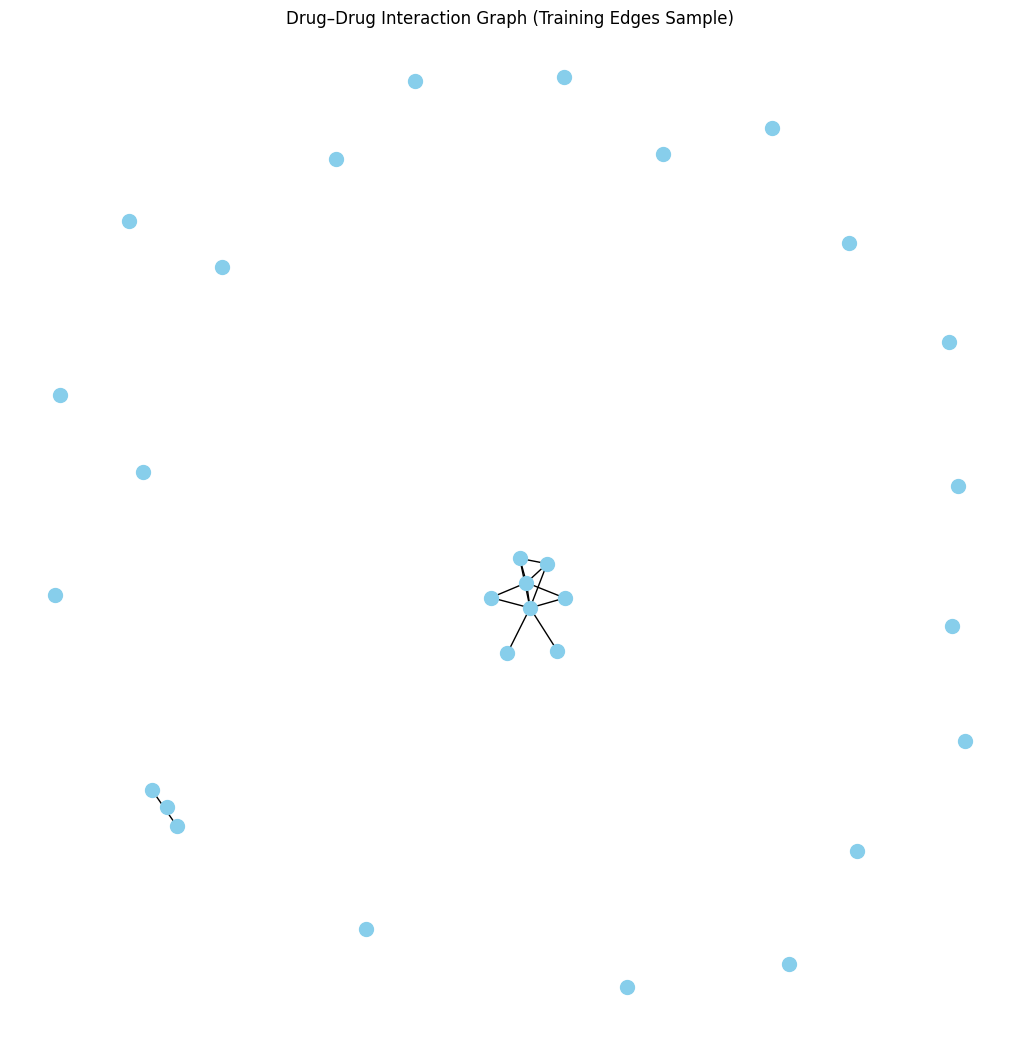

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Fix: build graph only from training edges
ddi_graph_vis = Data(x=ddi_graph.x, edge_index=ddi_graph.train_pos_edge_index)

# Convert to NetworkX for plotting
G = to_networkx(ddi_graph_vis, to_undirected=True)

# Plot a small subgraph
plt.figure(figsize=(10, 10))
subgraph = G.subgraph(list(G.nodes)[:30])  # first 30 nodes
nx.draw(subgraph, with_labels=False, node_size=100, node_color='skyblue')
plt.title("Drug–Drug Interaction Graph (Training Edges Sample)")
plt.show()


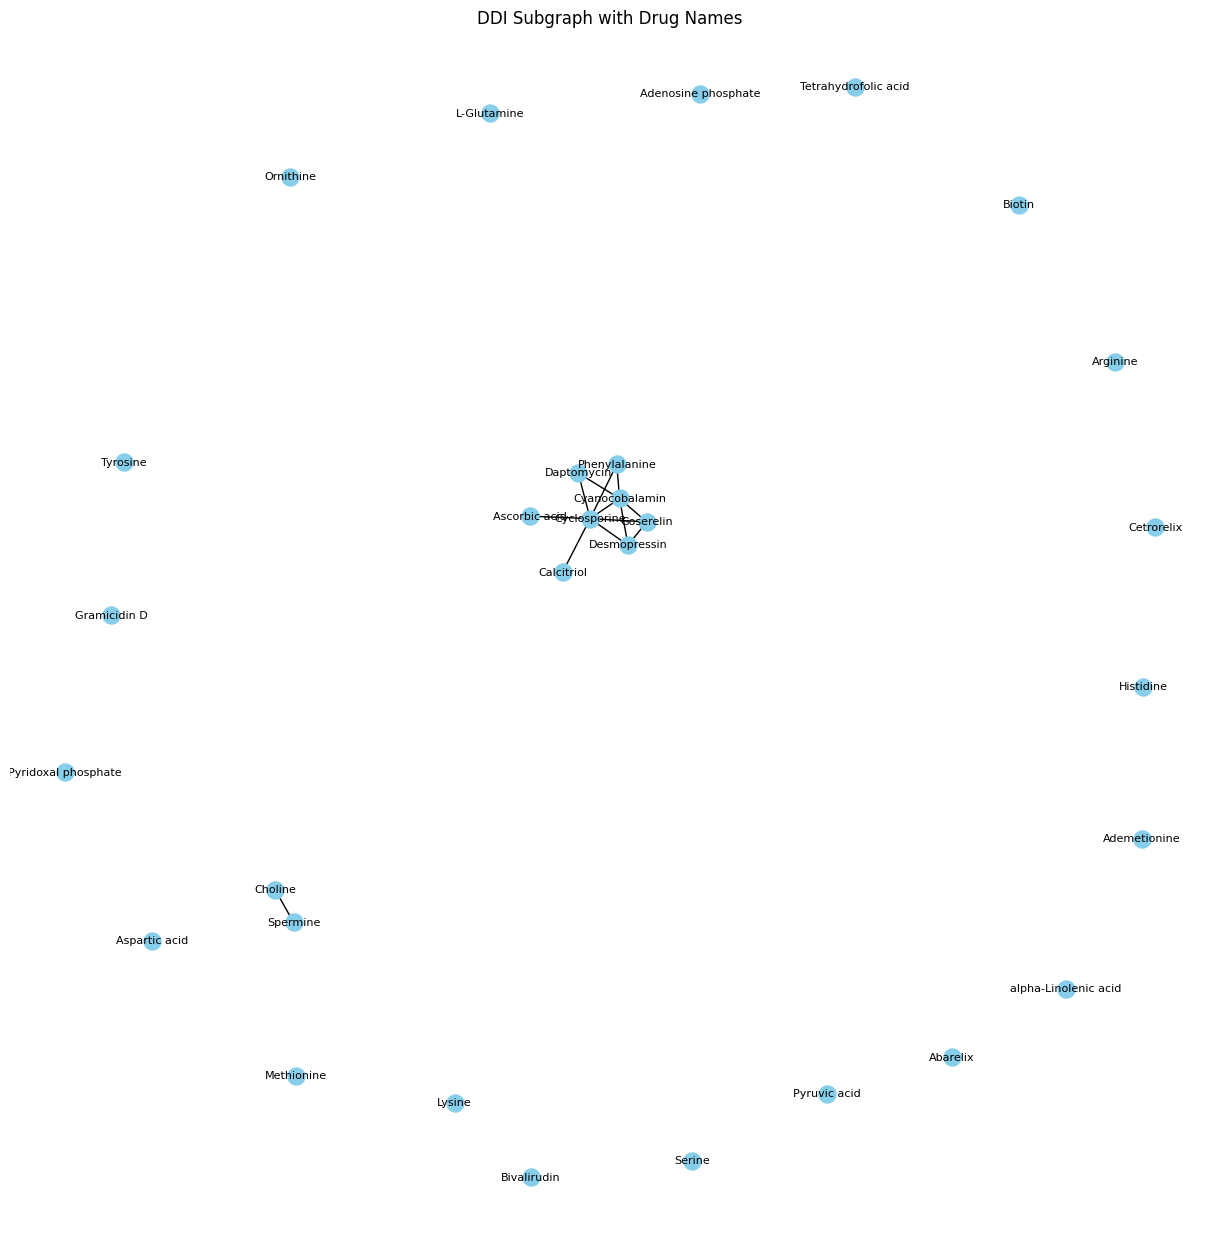

In [28]:
# FIXED: label drug names properly using actual node indices in the subgraph
subgraph_node_ids = list(subgraph.nodes)
index_to_id = {v: k for k, v in drug_id_to_index.items()}
id_to_name = dict(zip(drug_df['drugbank_id'], drug_df['name']))

# Correct name map for nodes in subgraph
name_map = {
    node: id_to_name.get(index_to_id.get(node), f"Drug {node}")
    for node in subgraph_node_ids
}

# Plot the subgraph with drug names as labels
plt.figure(figsize=(12, 12))
nx.draw(subgraph, labels=name_map, node_size=150, node_color='skyblue', font_size=8)
plt.title("DDI Subgraph with Drug Names")
plt.show()


In [29]:
torch.save(model.state_dict(), 'gnn_ddi_model.pt')
torch.save(z, 'drug_embeddings.pt')  # after model.encode(...)
